# Regression in PySpark's MLlib Project

Now it's time to put what you've learned to into action with a REAL project! 

You have been hired as a consultant to a cement production company who wants to be able to improve their customer experience around a number of areas like being able to provide recommendations to cusomters on optimal amounts of certian ingredients in the cement making process and perhaps even create an application where users can input their own values and received a predicted cement strength!

I have provided a list of question below to help guide you through this project but feel free to deviate and make this project your own! But first, a bit about this dataset.

### About this dataset 
This dataset contains 1030 instances of concrete samples, containing 9 attributes (8 continuous and 1 discreate), and 1 continuous quantitative output variable. There are no missing attribute values.

I've also provided the variable name, variable type, the measurement unit and a brief description of each variable in the dataset. The concrete compressive strength is the outcome variable for our analysis. The order of this listing corresponds to the order of numerals along the rows of the database.

Name -- Data Type -- Measurement -- Description

- Cement -- quantitative -- kg in a m3 mixture -- Input Variable 
- Blast Furnace Slag -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fly Ash -- quantitative -- kg in a m3 mixture -- Input Variable 
- Water -- quantitative -- kg in a m3 mixture -- Input Variable 
- Superplasticizer -- quantitative -- kg in a m3 mixture -- Input Variable 
- Coarse Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fine Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Age -- quantitative -- Day (1~365) -- Input Variable 
- Concrete compressive strength -- quantitative -- MPa -- Output Variable

**Source:** https://www.kaggle.com/maajdl/yeh-concret-data

**Dataset Name:** Concrete_Data.csv

## 1. Which features are the strongest predictors of cement strength?

Build your own ML model to figure this one out! This would be good information to give to our client so the sales reps can focus their efforts on certian ingredients to provide recommendations on. For example, if our clients had a customer that was struggling with their cement breaking, we could trouble shoot with them by starting with the factors that we know are important. 

## 2. For the following given inputs, what would be the estimated cement strength?

- Cement: 540
- Blast Furnace Slag: 0
- Fly Ash: 0
- Water: 162
- Superplasticizer: 2.5
- Coarse Aggregate: 1040
- Fine Aggregate: 676
- Age: 28

The correct answer is 79.99. Let's how close your prediction is!

## 3. Now see if you can ask users to input their own value for Age and return a predicted value for the cement stength. 

We did not cover this is in the lecture so you'll have to put your thinking cap on. Accepting user input in PySpark works just like it does in traditional Python.
<br>

val = input("Enter your value: ") 

## 4. Make recommendations of optimal values for cement ingredients (our features)

See if you can find the optimal amount of cement to recommend holding the rest of the values from the previous question constant, assuming that the higher the cement strength value the better. 

In [ ]:
# import findspark
# findspark.init()
!pip install pyspark
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("aggregate").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=da2528cc4ca3a08c1d689e47d5f86d96ac00a0c1342f4931f18cf45da354c948
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark
You are working with 1 core(s)


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

path = '/content/drive/MyDrive/Data Science Intake43/5. Spark/spark-scripts/section3/Datasets/'

Mounted at /content/drive/


In [ ]:
# Read in dependencies

# For data prep
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import * 
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer

# To check for multicolinearity
from pyspark.ml.stat import Correlation

# For training and evaluation
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
df = spark.read.csv(path+'Concrete_Data.csv',inferSchema=True,header=True)

### **Data Exploration**

In [ ]:
df.limit(5).toPandas()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [ ]:
df.printSchema()

root
 |-- cement: double (nullable = true)
 |-- slag: double (nullable = true)
 |-- flyash: double (nullable = true)
 |-- water: double (nullable = true)
 |-- superplasticizer: double (nullable = true)
 |-- coarseaggregate: double (nullable = true)
 |-- fineaggregate: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- csMPa: double (nullable = true)



In [ ]:
print(df.count())
print(len(df.columns))

1030
9


In [ ]:
# drop missing values if any
from pyspark.sql.functions import col,isnan,when,count
tmp = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])

In [ ]:
tmp.show()

+------+----+------+-----+----------------+---------------+-------------+---+-----+
|cement|slag|flyash|water|superplasticizer|coarseaggregate|fineaggregate|age|csMPa|
+------+----+------+-----+----------------+---------------+-------------+---+-----+
|     0|   0|     0|    0|               0|              0|            0|  0|    0|
+------+----+------+-----+----------------+---------------+-------------+---+-----+



No missing values exists

Since age value must be in range of 1 to 365, let's check if there's any outliers

In [ ]:
print('Max:', df.agg({'Age': 'max'}).show())

+--------+
|max(Age)|
+--------+
|     365|
+--------+

Max: None


In [ ]:
print('Min:', df.agg({'Age': 'min'}).show())

+--------+
|min(Age)|
+--------+
|       1|
+--------+

Min: None


Age is within range

### **Data Formating**

In [ ]:
input_columns = ["cement","slag","flyash","water","superplasticizer","coarseaggregate","fineaggregate","age"]
dependent_var = 'csMPa'

renamed = df.withColumnRenamed(dependent_var,'label')

In [ ]:
# Create empty dictionary d
d = {}
# Create a dictionary of percentiles you want to set
# We do top and bottom 1 % which is pretty common
for col in input_columns: 
    d[col] = renamed.approxQuantile(col,[0.01,0.99],0.25) #if you want to make it go faster increase the last number
#Now fill in the values
for col in input_columns:
    skew = renamed.agg(skewness(renamed[col])).collect() #check for skewness
    skew = skew[0][0]
    # This function will floor, cap and then log+1 (just in case there are 0 values)
    if skew > 1:
        renamed = renamed.withColumn(col, \
        log(when(df[col] < d[col][0],d[col][0])\
        .when(renamed[col] > d[col][1], d[col][1])\
        .otherwise(renamed[col] ) +1).alias(col))
        print(col+" has been treated for positive (right) skewness. (skew =)",skew,")")
    elif skew < -1:
        renamed = renamed.withColumn(col, \
        exp(when(df[col] < d[col][0],d[col][0])\
        .when(renamed[col] > d[col][1], d[col][1])\
        .otherwise(renamed[col] )).alias(col))
        print(col+" has been treated for negative (left) skewness. (skew =",skew,")")

age has been treated for positive (right) skewness. (skew =) 3.2644145354168086 )


In [ ]:
features_list = input_columns
assembler = VectorAssembler(inputCols=features_list,outputCol='features')
final_data = assembler.transform(renamed).select('features','label')
final_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[540.0,0.0,0.0,16...|79.99|
|[540.0,0.0,0.0,16...|61.89|
|[332.5,142.5,0.0,...|40.27|
|[332.5,142.5,0.0,...|41.05|
|[198.6,132.4,0.0,...| 44.3|
+--------------------+-----+
only showing top 5 rows



### Check features correlation

In [ ]:
from pyspark.ml.stat import Correlation
pearsonCorr = Correlation.corr(final_data, 'features', 'pearson').collect()[0][0]
array = pearsonCorr.toArray()

In [ ]:
import numpy
i = 1
for item in array:
    print("start item", i)
    for innerItem in item:
        print(numpy.round(innerItem,3) , end =" ")
    print(" ")
    print("end of item", i)
    print(" ")
    i = i + 1

start item 1
1.0 -0.275 -0.397 -0.082 0.092 -0.109 -0.223 0.003  
end of item 1
 
start item 2
-0.275 1.0 -0.324 0.107 0.043 -0.284 -0.282 -0.021  
end of item 2
 
start item 3
-0.397 -0.324 1.0 -0.257 0.378 -0.01 0.079 -0.02  
end of item 3
 
start item 4
-0.082 0.107 -0.257 1.0 -0.658 -0.182 -0.451 0.17  
end of item 4
 
start item 5
0.092 0.043 0.378 -0.658 1.0 -0.266 0.223 -0.048  
end of item 5
 
start item 6
-0.109 -0.284 -0.01 -0.182 -0.266 1.0 -0.178 -0.038  
end of item 6
 
start item 7
-0.223 -0.282 0.079 -0.451 0.223 -0.178 1.0 -0.115  
end of item 7
 
start item 8
0.003 -0.021 -0.02 0.17 -0.048 -0.038 -0.115 1.0  
end of item 8
 


### Which are correlated?

Split Data

In [ ]:
train,test = final_data.randomSplit([0.75,0.25])

### **Random Forest**

In [ ]:
regressor = LinearRegression()
fitModel = regressor.fit(train)

In [ ]:
evaluator = RegressionEvaluator(metricName="rmse")

In [ ]:
#predict
predictions = fitModel.transform(test)

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 7.29985


### **Linear Regression with CV**

In [ ]:
regressor = LinearRegression()

paramGrid = (ParamGridBuilder() \
             .addGrid(regressor.maxIter, [10, 15]) \
             .addGrid(regressor.regParam, [0.1, 0.01]) \
             .build())

evaluator = RegressionEvaluator(metricName="rmse")

#Cross Validator requires all of the following parameters:
crossval = CrossValidator(estimator=regressor,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3) 

print('\033[1m' + "Linear Regression Model Summary WITH cross validation:"+ '\033[0m')
print(" ")
# Run cross validations
fitModel = crossval.fit(train)

# Extract Best model
LR_BestModel = fitModel.bestModel

# Get Model Summary Statistics
# ModelSummary = fitModel.bestModel.summary
ModelSummary = LR_BestModel.summary
print("Coefficient Standard Errors: ")
coeff_ste = ModelSummary.coefficientStandardErrors
result = spark.createDataFrame(zip(input_columns,coeff_ste), schema=['feature','coeff std error'])
print(result.orderBy(result["coeff std error"].desc()).show(truncate=False))
print(" ")
print("P Values: ") 
# Then zip with input_columns list and create a df
pvalues = ModelSummary.pValues
result = spark.createDataFrame(zip(input_columns,pvalues), schema=['feature','P-Value'])
print(result.orderBy(result["P-Value"].desc()).show(truncate=False))
print(" ")

# Use test set here so we can measure the accuracy of our model on new data
ModelPredictions = fitModel.transform(test)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
test_results = evaluator.evaluate(ModelPredictions)
print('RMSE:', test_results)

Linear Regression Model Summary WITH cross validation:
 
Coefficient Standard Errors: 
+----------------+--------------------+
|feature         |coeff std error     |
+----------------+--------------------+
|age             |0.250130518792412   |
|superplasticizer|0.07507569856624512 |
|water           |0.03225891573635566 |
|flyash          |0.010090798682483429|
|fineaggregate   |0.008696609907279582|
|slag            |0.008209802284997287|
|coarseaggregate |0.007654722950445365|
|cement          |0.006915136798573747|
+----------------+--------------------+

None
 
P Values: 
+----------------+---------------------+
|feature         |P-Value              |
+----------------+---------------------+
|superplasticizer|0.0317322493167882   |
|water           |4.0166169962385645E-4|
|coarseaggregate |1.0787963701641701E-4|
|fineaggregate   |2.8620182422223195E-5|
|age             |0.0                  |
|cement          |0.0                  |
|flyash          |0.0                  |
|sla

### **Gradient Boost Regressor**

In [ ]:
regressor = GBTRegressor()

# Add parameters of your choice here:
paramGrid = (ParamGridBuilder() \
                           .addGrid(regressor.maxDepth, [2, 5, 10])
                           .addGrid(regressor.maxBins, [5, 10, 20])
                           .build())

#Cross Validator requires all of the following parameters:
crossval = CrossValidator(estimator=regressor,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)
# Fit Model: Run cross-validation, and choose the best set of parameters.
fitModel = crossval.fit(train)

# Get Best Model
GBT_BestModel = fitModel.bestModel

# FEATURE IMPORTANCES
# Estimate of the importance of each feature.
# Each feature’s importance is the average of its importance across all trees 
# in the ensemble The importance vector is normalized to sum to 1. 
print(" ")
print('\033[1m' + " Feature Importances"+ '\033[0m')
print("(Scores add up to 1)")
print("Lowest score is the least important")
print(" ")
GBT_featureImportances = GBT_BestModel.featureImportances.toArray()
# Convert from numpy array to list
imp_scores = []
for x in GBT_featureImportances:
    imp_scores.append(float(x))
# Then zip with input_columns list and create a df
result = spark.createDataFrame(zip(input_columns,imp_scores), schema=['feature','score'])
print(result.orderBy(result["score"].desc()).show(truncate=False))

# Make predictions.
# PySpark will automatically use the best model when you call fitmodel
predictions = fitModel.transform(test)

# And then apply it your predictions dataframe
rmse = evaluator.evaluate(predictions)
print(rmse)

 
 Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
+----------------+--------------------+
|feature         |score               |
+----------------+--------------------+
|age             |0.23653583044014115 |
|cement          |0.19803397154527458 |
|water           |0.1360648492305606  |
|fineaggregate   |0.11507490360700398 |
|slag            |0.10681596967246565 |
|coarseaggregate |0.07539248688631538 |
|superplasticizer|0.07296171371768165 |
|flyash          |0.059120274900556914|
+----------------+--------------------+

None
5.781907300522872


### **Random Forest Regressor**

In [ ]:
regressor = RandomForestRegressor()

# Add parameters of your choice here:
paramGrid = (ParamGridBuilder() \
                           .addGrid(regressor.maxDepth, [2, 5, 10])
                           .addGrid(regressor.maxBins, [5, 10, 20])
               .addGrid(regressor.numTrees, [5, 20])
             .build())

#Cross Validator requires all of the following parameters:
crossval = CrossValidator(estimator=regressor,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3) 
# Fit Model: Run cross-validation, and choose the best set of parameters.
fitModel = crossval.fit(train)

# Get Best Model
RF_BestModel = fitModel.bestModel

# FEATURE IMPORTANCES
# Estimate of the importance of each feature.
# Each feature’s importance is the average of its importance across all trees 
# in the ensemble The importance vector is normalized to sum to 1. 
print(" ")
print('\033[1m' + " Feature Importances"+ '\033[0m')
print("(Scores add up to 1)")
print("Lowest score is the least important")
print(" ")
RF_featureImportances = RF_BestModel.featureImportances.toArray()
# Convert from numpy array to list
imp_scores = []
for x in RF_featureImportances:
    imp_scores.append(float(x))
# Then zip with input_columns list and create a df
result = spark.createDataFrame(zip(input_columns,imp_scores), schema=['feature','score'])
print(result.orderBy(result["score"].desc()).show(truncate=False))

# Make predictions.
# PySpark will automatically use the best model when you call fitmodel
predictions = fitModel.transform(test)

# And then apply it your predictions dataframe
rmse = evaluator.evaluate(predictions)
print("RMSE: ", rmse)

 
 Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
+----------------+--------------------+
|feature         |score               |
+----------------+--------------------+
|age             |0.33340438014723595 |
|cement          |0.24701935757226173 |
|water           |0.12246851126720892 |
|superplasticizer|0.07166172826818085 |
|fineaggregate   |0.06817043889904896 |
|slag            |0.06031099223504194 |
|coarseaggregate |0.058228579553014456|
|flyash          |0.03873601205800723 |
+----------------+--------------------+

None
RMSE:  5.717237433613214


Accordingly, Random Forest Regressor had the least RMSE, thus, it will be utilized throughout the pipeline

## Given the following values for features, what is the predicted csMPA

In [ ]:
input = [(540.0, 0.0, 0.0, 162.0, 2.5, 1040.0, 676.0, 28, 79.99)]

schema = StructType([ \
          StructField("cement",FloatType(),True), \
          StructField("slag",FloatType(),True), \
          StructField("flyash",FloatType(),True), \
          StructField("water", FloatType(), True), \
          StructField("superplasticizer", FloatType(), True), \
          StructField("coarseaggregate", FloatType(), True), \
          StructField("fineaggregate", FloatType(), True), \
          StructField("age", IntegerType(), True), \
          StructField("label", FloatType(), True)\
        ])

pred_df = spark.createDataFrame(data=input, schema=schema)
pred_df.show(3)


+------+----+------+-----+----------------+---------------+-------------+---+-----+
|cement|slag|flyash|water|superplasticizer|coarseaggregate|fineaggregate|age|label|
+------+----+------+-----+----------------+---------------+-------------+---+-----+
| 540.0| 0.0|   0.0|162.0|             2.5|         1040.0|        676.0| 28|79.99|
+------+----+------+-----+----------------+---------------+-------------+---+-----+



In [ ]:
features_list = input_columns
assembler = VectorAssembler(inputCols=features_list,outputCol='features')
final_data = assembler.transform(pred_df).select('features','label')
final_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[540.0,0.0,0.0,16...|79.99|
+--------------------+-----+



In [ ]:
predicted_val = fitModel.transform(final_data)

In [ ]:
predicted_val.show()

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|[540.0,0.0,0.0,16...|79.99|287.2002070879132|
+--------------------+-----+-----------------+



In [ ]:
rmse = evaluator.evaluate(predicted_val)
print("RMSE: ", rmse)

RMSE:  207.21020922414368


### **3: Input age**

In [ ]:
age = input('Enter age: ')

TypeError: ignored

In [ ]:
input = [(540.0, 0.0, 0.0, 162.0, 2.5, 1040.0, 676.0, age, 79.99)]

schema = StructType([ \
          StructField("cement",FloatType(),True), \
          StructField("slag",FloatType(),True), \
          StructField("flyash",FloatType(),True), \
          StructField("water", FloatType(), True), \
          StructField("superplasticizer", FloatType(), True), \
          StructField("coarseaggregate", FloatType(), True), \
          StructField("fineaggregate", FloatType(), True), \
          StructField("age", IntegerType(), True), \
          StructField("label", FloatType(), True)\
        ])

pred_df = spark.createDataFrame(data=input, schema=schema)
pred_df.show(3)

In [ ]:
features_list = input_columns
assembler = VectorAssembler(inputCols=features_list,outputCol='features')
final_data = assembler.transform(pred_df).select('features','label')
final_data.show(5)

In [ ]:
predicted_val = fitModel.transform(final_data)
predicted_val.show()

## **4. Recommendation:**

In [ ]:
print('Max:', df.agg({'Cement': 'max'}).show())

+-----------+
|max(Cement)|
+-----------+
|      540.0|
+-----------+

Max: None


In [ ]:
print('Min:', df.agg({'Cement': 'min'}).show())

+-----------+
|min(Cement)|
+-----------+
|      102.0|
+-----------+

Min: None


Since the values start from almost 100 and the max at 540, then, I'll try from to loop from 100-1000

In [ ]:
schema = StructType([ \
          StructField("cement",FloatType(),True), \
          StructField("slag",FloatType(),True), \
          StructField("flyash",FloatType(),True), \
          StructField("water", FloatType(), True), \
          StructField("superplasticizer", FloatType(), True), \
          StructField("coarseaggregate", FloatType(), True), \
          StructField("fineaggregate", FloatType(), True), \
          StructField("age", IntegerType(), True) \
        ])

In [ ]:
cement_value = []
predictions = []

for cement in range(100,1000,10):

  input = [(float(cement), 0.0, 0.0, 162.0, 2.5, 1040.0, 676.0, 28)]
  pred_df = spark.createDataFrame(data=input, schema=schema)

  features_list = input_columns
  assembler = VectorAssembler(inputCols=features_list,outputCol='features')
  final_data = assembler.transform(pred_df).select('features')
  predicted_val = fitModel.transform(final_data)

  cement_value.append(cement)
  predictions.append(predicted_val.collect()[0][1])


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

[(100.0, 1000.0)]

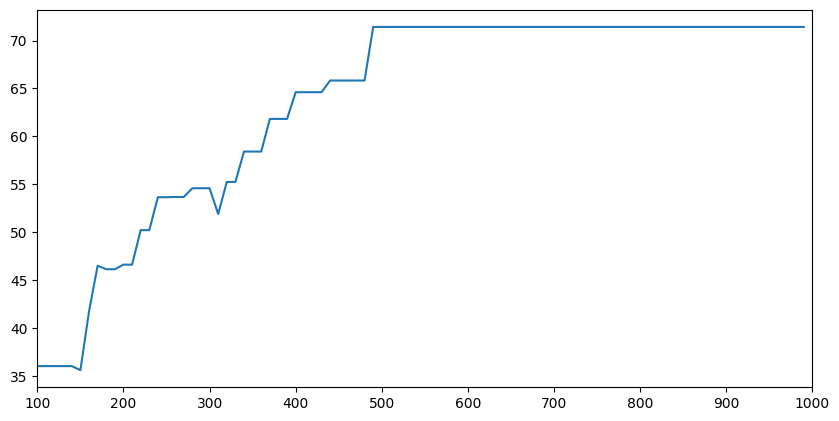

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
sns.lineplot(
    x=cement_value, y=predictions,
    markers=True, dashes=False)
ax.set(xlim=(100, 1000))

### Since the predictions became constant after around 490 cement strength, we can recommed the value to be **500**

In [ ]:
cement = 500.0
input = [(cement, 0.0, 0.0, 162.0, 2.5, 1040.0, 676.0, 28)]
pred_df = spark.createDataFrame(data=input, schema=schema)

features_list = input_columns
assembler = VectorAssembler(inputCols=features_list,outputCol='features')
final_data = assembler.transform(pred_df).select('features')
predicted_val = fitModel.transform(final_data)

predicted_val.show()

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[500.0,0.0,0.0,16...|71.41791013071897|
+--------------------+-----------------+

